In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

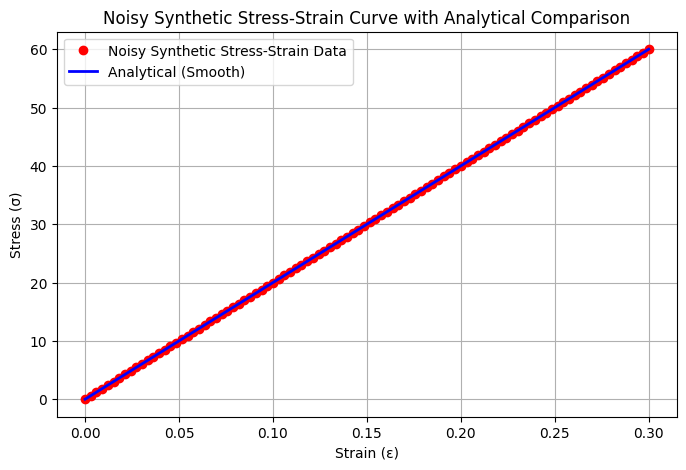

In [2]:

E_modulus = 200  # Elastic modulus (MPa)
C1, C2 = 0, 0  # Nonlinear coefficients
noise_level = 0 

def generate_nonlinear_elastic_data(epsilon_values, E, C1, C2, noise_level):
    sigma = E * epsilon_values + C1 * epsilon_values ** 2 + C2 * epsilon_values ** 3
    noise = noise_level * np.random.randn(*epsilon_values.shape)
    return sigma + noise

epsilon_train = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_train = generate_nonlinear_elastic_data(epsilon_train, E_modulus, C1, C2, noise_level).astype(np.float32)
plt.figure(figsize=(8, 5))
plt.plot(epsilon_train, sigma_train, 'ro', label='Noisy Synthetic Stress-Strain Data')


epsilon_analytical = np.linspace(0, 0.3, 100).reshape(-1, 1).astype(np.float32)
sigma_analytical = E_modulus * epsilon_analytical + C1 * epsilon_analytical ** 2 + C2 * epsilon_analytical ** 3
plt.plot(epsilon_analytical, sigma_analytical, 'b-', linewidth=2, label='Analytical (Smooth)')

# Labels and title
plt.xlabel('Strain (ε)')
plt.ylabel('Stress (σ)')
plt.title('Noisy Synthetic Stress-Strain Curve with Analytical Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Convert to PyTorch tensors
epsilon_train_tensor = torch.tensor(epsilon_train, requires_grad=False)
sigma_train_tensor = torch.tensor(sigma_train)


In [3]:
class BlackBoxNN(nn.Module):
    def __init__(self, hidden_dim, num_hidden_layers):
        super(BlackBoxNN, self).__init__()
        self.input_layer = nn.Linear(1, hidden_dim)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(hidden_dim, hidden_dim) for _ in range(num_hidden_layers)]
        )
        
        self.output_layer = nn.Linear(hidden_dim, 1)

    def forward(self, epsilon):
        x = torch.relu(self.input_layer(epsilon))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        
        return self.output_layer(x)


Epoch 0, Loss: 1367.8224609375
Epoch 100, Loss: 0.04011705312877893
Epoch 200, Loss: 0.0004403806506888941
Epoch 300, Loss: 2.4357256788789526e-05
Epoch 400, Loss: 6.648185953963548e-06
Epoch 500, Loss: 2.0392389978951544e-06
Epoch 600, Loss: 4.4370280920702496e-05
Epoch 700, Loss: 7.146732592389071e-07
Epoch 800, Loss: 2.4613347750346293e-06
Epoch 900, Loss: 6.066060723242117e-06
Epoch 1000, Loss: 6.465491915150778e-06
Epoch 1100, Loss: 6.830999838712159e-05
Epoch 1200, Loss: 0.00042221810668706893
Epoch 1300, Loss: 0.0007719361467752605
Epoch 1400, Loss: 8.268955320090753e-05
Epoch 1500, Loss: 6.984574538364541e-06
Epoch 1600, Loss: 1.660199064644985e-05
Epoch 1700, Loss: 0.0007978522405028343
Epoch 1800, Loss: 3.038472408661619e-05
Epoch 1900, Loss: 0.011831750301644206
Epoch 2000, Loss: 5.454608755826485e-05
Epoch 2100, Loss: 0.00023963503761478933
Epoch 2200, Loss: 1.1449834564700723e-05
Epoch 2300, Loss: 1.2215109672979451e-05
Epoch 2400, Loss: 1.2245160414749989e-05
Epoch 2500, 

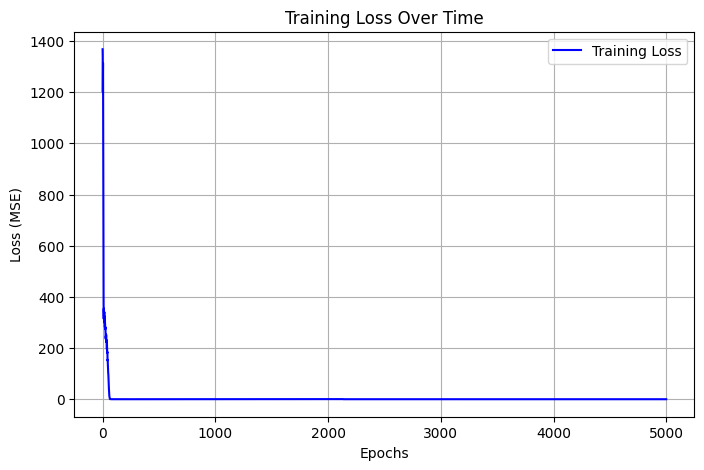

In [4]:

hidden_dim = 60 
num_hidden_layers = 3  
net = BlackBoxNN(hidden_dim, num_hidden_layers)
loss_fn = nn.MSELoss()
epochs = 5000
lr = 1e-3
batch_size = 16  
optimizer = optim.Adam(net.parameters(), lr=lr)
loss_history = []

for epoch in range(epochs):
    permutation = torch.randperm(epsilon_train_tensor.size(0))  # Shuffle the data at each epoch
    
    epoch_loss = 0  
    
    for i in range(0, epsilon_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        epsilon_batch = epsilon_train_tensor[indices]
        sigma_batch = sigma_train_tensor[indices]
        
        optimizer.zero_grad()
        
        pred_stress = net(epsilon_batch)
        
        loss = loss_fn(pred_stress, sigma_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / (epsilon_train_tensor.size(0) / batch_size)
    loss_history.append(avg_epoch_loss)
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {avg_epoch_loss}')

# Save trained model for future use
torch.save(net, "black_box_nn_LE.pth")

# Visualize the training loss
plt.figure(figsize=(8, 5))
plt.plot(range(epochs), loss_history, 'b-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

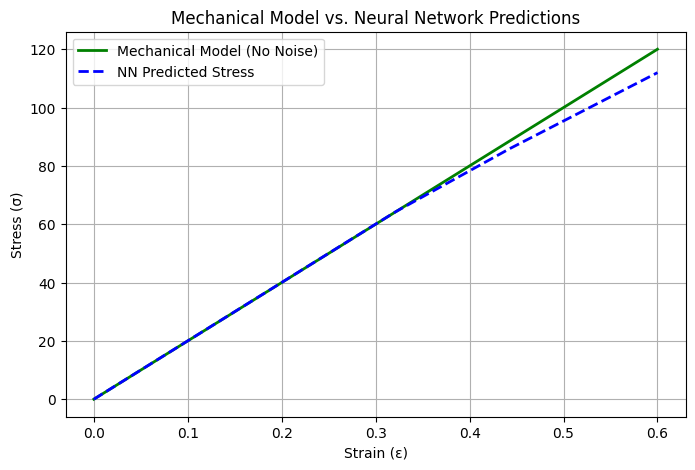

In [5]:
epsilon_test = np.linspace(0, 0.6, 100).reshape(-1, 1).astype(np.float32)
epsilon_test_tensor = torch.tensor(epsilon_test, requires_grad=False)
pred_sigma_test = net(epsilon_test_tensor).detach().numpy()
sigma_mechanical_model = generate_nonlinear_elastic_data(epsilon_test, E_modulus, C1, C2, 0)
plt.figure(figsize=(8, 5))
plt.plot(epsilon_test, sigma_mechanical_model, 'g-', label='Mechanical Model (No Noise)', linewidth=2)
plt.plot(epsilon_test, pred_sigma_test, 'b--', label='NN Predicted Stress', linewidth=2)
plt.xlabel('Strain (ε)')
plt.ylabel('Stress (σ)')
plt.title('Mechanical Model vs. Neural Network Predictions')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
net_loaded = torch.load("black_box_nn.pth")

C:\Users\A_structure\AppData\Local\Temp\ipykernel_11912\525425144.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_loaded = torch.load("black_box_nn.pth")
